# Hodoscope Efficiency

In [1]:
#include <iostream>
#include <vector>

In [2]:
class TFile;
class TTree;
class TH1D;
class TH2D;
class TEfficiency;
class TString;
class TCanvas;

In [3]:
using namespace std;

Build a simple class for analysis.

In [4]:
class model
{
    public:
    TFile* file;
    TTree* tree;
    int nevents;
    
    // for whole plane
    vector<TH1D*> hall;
    vector<TH1D*> hpass;
    vector<TH1D*> hdiff;
    vector<TEfficiency*> effi;
    
    // 1st half of hodoscope
    vector<TH1D*> hall1;
    vector<TH1D*> hpass1;
    vector<TH1D*> hdiff1;
    vector<TEfficiency*> effi1;
    
    // 2nd half of hodocope
    vector<TH1D*> hall2;
    vector<TH1D*> hpass2;
    vector<TH1D*> hdiff2;
    vector<TEfficiency*> effi2;
    
    vector<int> hodo;
    
    vector<int>* detectorID = 0;
    vector<int>* elementID_exp = 0;
    vector<int>* elementID_closest = 0;
    vector<int>* ele24 = 0;
    vector<int>* ele42 = 0;
    
    int nHits;
    double chisq;
    
    TH1D* hnhits = new TH1D("hnhits", "; nhits; counts", 20, 0.0, 20.0);
    TH1D* hchisq = new TH1D("hchisq", "; chisq; counts", 20, 0.0, 20.0);
    TH2D* hele24 = new TH2D("hele24", "; ele_id(H2Y); ele_id(H4Y)", 16, 0.5, 16.5, 16, 0.5, 16.5);
    TH2D* hele42 = new TH2D("hele42", "; ele_id(H2Y); ele_id(H4Y)", 16, 0.5, 16.5, 16, 0.5, 16.5);
    
    TCanvas* can;
    
    model();
    void set_det(int id);
    void plane_effi(int id);
    void half_effi(int id);
    void ana();
    void print(TEfficiency* e0, TH1D* h0);
    void done();
};

In [5]:
model::model()
{
    file = TFile::Open("../ana.root", "READ");
    tree = (TTree*)file->Get("save");
    nevents = tree->GetEntries();
    
    //cout << "nevets : " << nevents << endl;
    
    tree->SetBranchAddress("detectorID", &detectorID);
    tree->SetBranchAddress("elementID_exp", &elementID_exp);
    tree->SetBranchAddress("elementID_closest", &elementID_closest);
    tree->SetBranchAddress("nHits", &nHits);
    tree->SetBranchAddress("chisq", &chisq);
    tree->SetBranchAddress("ele24", &ele24);
    tree->SetBranchAddress("ele42", &ele42);
}

In [6]:
void model::set_det(int id)
{
    hodo.push_back(id);
}

In [7]:
void model::plane_effi(int id)
{
    TString name1 = Form("hall_%d", id);
    TString title1 = Form("; ele_id[det_id = %d]; counts", id);
    
    TString name2 = Form("hpass_%d", id);
    
    TString name3 = Form("hdiff_%d", id);
    TString title2 = Form("; exp_id - close_id [det_id = %d]; counts", id);
    
    TH1D* h1 = new TH1D(name1.Data(), title1.Data(), 16, 0.5, 16.5);
    TH1D* h2 = new TH1D(name2.Data(), title1.Data(), 16, 0.5, 16.5);
    TH1D* h3 = new TH1D(name3.Data(), title2.Data(), 21, -10., 10.);
    
    for(int i = 0; i < nevents; i++)
    {
        tree->GetEntry(i);
        
        hnhits->Fill(nHits);
        hchisq->Fill(chisq);
        
        // for debugging
        if(ele24->size()==2){hele24->Fill(ele24->at(0), ele24->at(1));}
        if(ele42->size()==2){hele42->Fill(ele42->at(0), ele42->at(1));}
        
        int ndet = detectorID->size();
        
        for(int j = 0; j < ndet; j++)
        {
            if(detectorID->at(j) == id)
            {
                h1->Fill(elementID_exp->at(j));
                if(elementID_closest->at(j) > 0)
                {
                    h2->Fill(elementID_exp->at(j));
                    h3->Fill(elementID_exp->at(j) - elementID_closest->at(j));
                }
            }
        }
    }
    
    TEfficiency* e1 = new TEfficiency(*h2, *h1);
    TString ename = Form("effi_%d", id);
    TString etitle = Form("; ele_id [det_id = %d]; efficiency", id);
    e1->SetNameTitle(ename.Data(), etitle.Data());
    
    hall.push_back(h1);
    hpass.push_back(h2);
    hdiff.push_back(h3);
    effi.push_back(e1);
}

In [8]:
void model::half_effi(int id)
{
    TString name1 = Form("hall1_%d", id);
    TString name2 = Form("hall2_%d", id);
    TString title1 = Form("ele_id < 9; ele_id[det_id = %d]; counts", id);
    TString title2 = Form("ele_id > 8; ele_id[det_id = %d]; counts", id);
    
    TString name3 = Form("hpass1_%d", id);
    TString name4 = Form("hpass2_%d", id);
    
    TString name5 = Form("hdiff1_%d", id);
    TString name6 = Form("hdiff2_%d", id);
    TString title3 = Form("ele_id < 9; exp_id - close_id [det_id = %d]; counts", id);
    TString title4 = Form("ele_id > 8; exp_id - close_id [det_id = %d]; counts", id);
    
    TH1D* h1 = new TH1D(name1.Data(), title1.Data(), 16, 0.5, 16.5);
    TH1D* h2 = new TH1D(name2.Data(), title2.Data(), 16, 0.5, 16.5);
    
    TH1D* h3 = new TH1D(name3.Data(), title1.Data(), 16, 0.5, 16.5);
    TH1D* h4 = new TH1D(name4.Data(), title2.Data(), 16, 0.5, 16.5);
    
    
    TH1D* h5 = new TH1D(name5.Data(), title3.Data(), 21, -10., 10.);
    TH1D* h6 = new TH1D(name6.Data(), title4.Data(), 21, -10., 10.);
    
    for(int i = 0; i < nevents; i++)
    {
        tree->GetEntry(i);
        
        int ndet = detectorID->size();
        
        for(int j = 0; j < ndet; j++)
        {
            if(detectorID->at(j) == id)
            {
                if(elementID_exp->at(j) < 9)
                {
                    h1->Fill(elementID_exp->at(j));
                    if(elementID_closest->at(j) > 0)
                    {
                        h3->Fill(elementID_exp->at(j));
                        h5->Fill(elementID_exp->at(j) - elementID_closest->at(j));
                    }
                }
                if(elementID_exp->at(j) > 8)
                {
                    h2->Fill(elementID_exp->at(j));
                    if(elementID_closest->at(j) > 0)
                    {
                        h4->Fill(elementID_exp->at(j));
                        h6->Fill(elementID_exp->at(j) - elementID_closest->at(j));
                    }
                }
            }
        }
    }
    
    TEfficiency* e1 = new TEfficiency(*h3, *h1);
    TString ename1 = Form("effi1_%d", id);
    TString etitle1 = Form("ele_id < 9; ele_id [det_id = %d]; efficiency", id);
    e1->SetNameTitle(ename1.Data(), etitle1.Data());
    
    TEfficiency* e2 = new TEfficiency(*h4, *h2);
    TString ename2 = Form("effi2_%d", id);
    TString etitle2 = Form("ele_id > 8; ele_id [det_id = %d]; efficiency", id);
    e2->SetNameTitle(ename2.Data(), etitle2.Data());
    
    hall1.push_back(h1);
    hpass1.push_back(h3);
    hdiff1.push_back(h5);
    effi1.push_back(e1);
    
    hall2.push_back(h2);
    hpass2.push_back(h4);
    hdiff2.push_back(h6);
    effi2.push_back(e2);
}

In [9]:
void model::ana()
{
    int nhodo = hodo.size();
    //cout << "nhodo : " << nhodo << endl;
    
    for(int i = 0; i < nhodo; i++)
    {
        plane_effi(hodo.at(i));
        half_effi(hodo.at(i));
    }
}

In [10]:
void model::print(TEfficiency* e0, TH1D* h0)
{
    can = new TCanvas(e0->GetName(), "", 1000, 500);
    can->Divide(2);
    can->cd(1);
    
    e0->SetMarkerColor(2);
    e0->SetMarkerStyle(8);
    e0->Draw("APE1");
    can->Update();
    
    can->cd(2);
    h0->SetFillColor(kAzure+10);
    h0->Draw();
    can->Update();
    
    can->Draw();
    
    TString cname = Form("../pics/%s.png", e0->GetName());
    can->Print(cname.Data());
}

In [11]:
void model::done()
{
    TCanvas* c1 = new TCanvas("c1", "", 500, 500);
    hnhits->SetFillColor(kAzure+10);
    hnhits->Draw();
    c1->Update();
    c1->Draw();
    c1->Print("../pics/nhits.png");
    
    hchisq->SetFillColor(kAzure+10);
    hchisq->Draw();
    c1->Update();
    c1->Draw();
    c1->Print("../pics/chisq.png");
    
    // for debugging only
    hele24->Draw("COLZ");
    c1->Update();
    c1->Draw();
    c1->Print("../pics/ele24.png");
    
    hele42->Draw("COLZ");
    c1->Update();
    c1->Draw();
    c1->Print("../pics/ele42.png");
    
    int neffi = effi.size();
    for(int i = 0; i < neffi; i++)
    {
        print(effi.at(i), hdiff.at(i));
        print(effi1.at(i), hdiff1.at(i));
        print(effi2.at(i), hdiff2.at(i));
    }
}

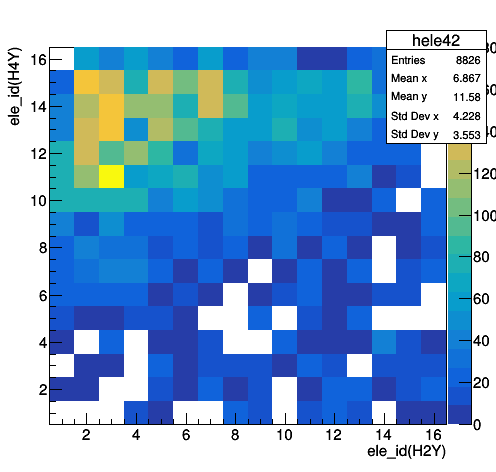

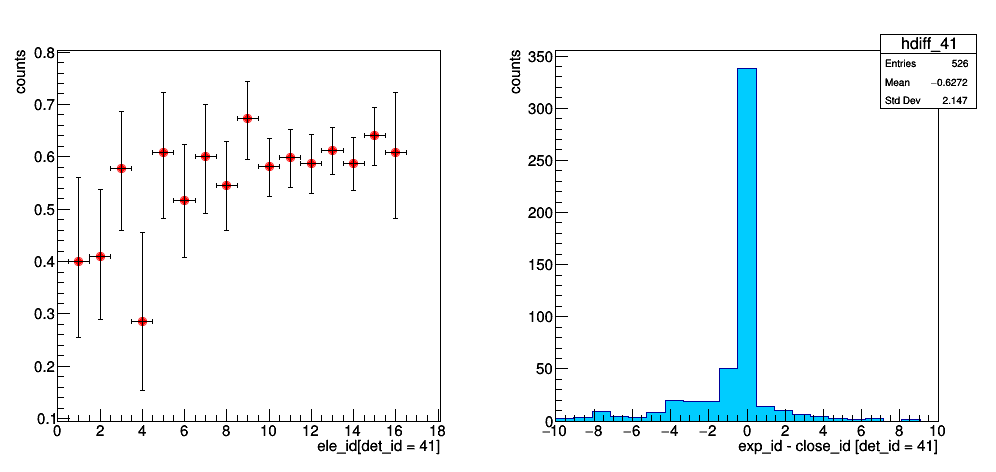

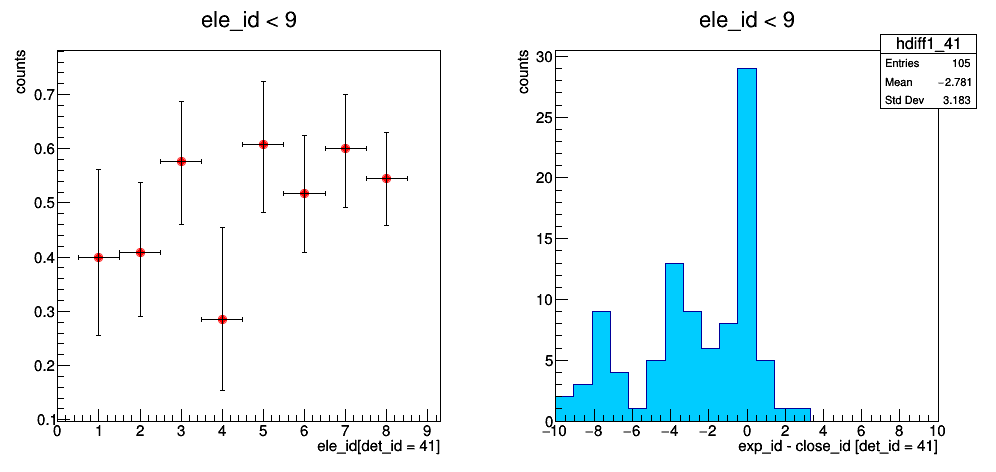

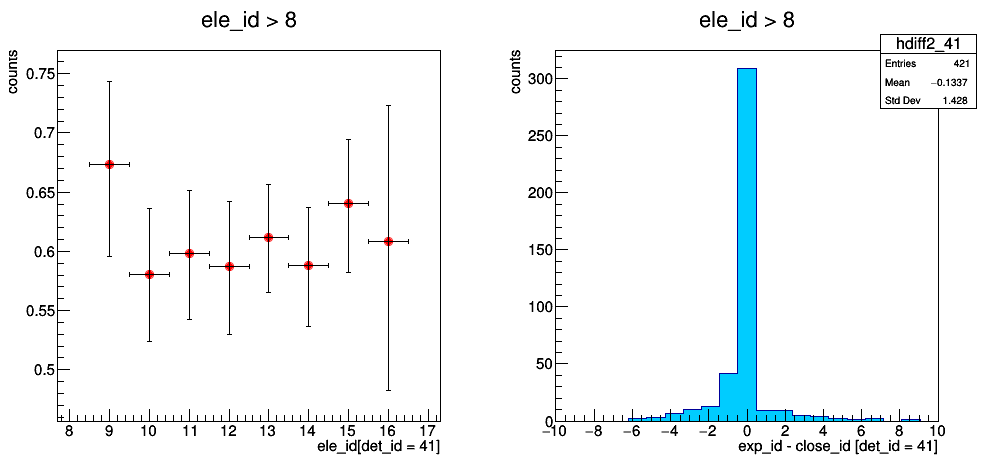

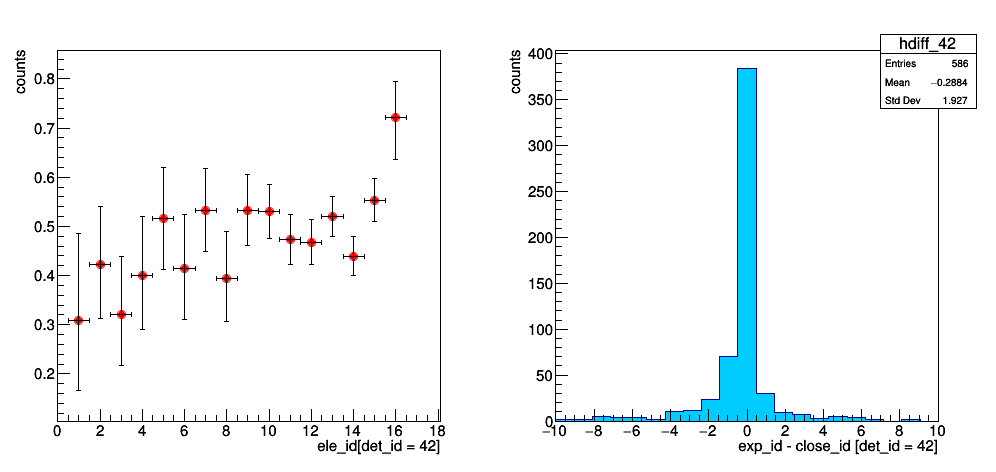

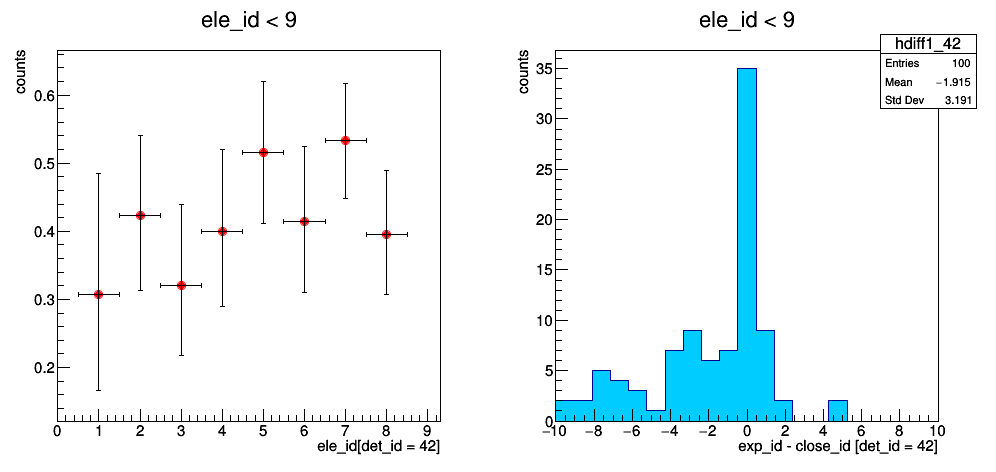

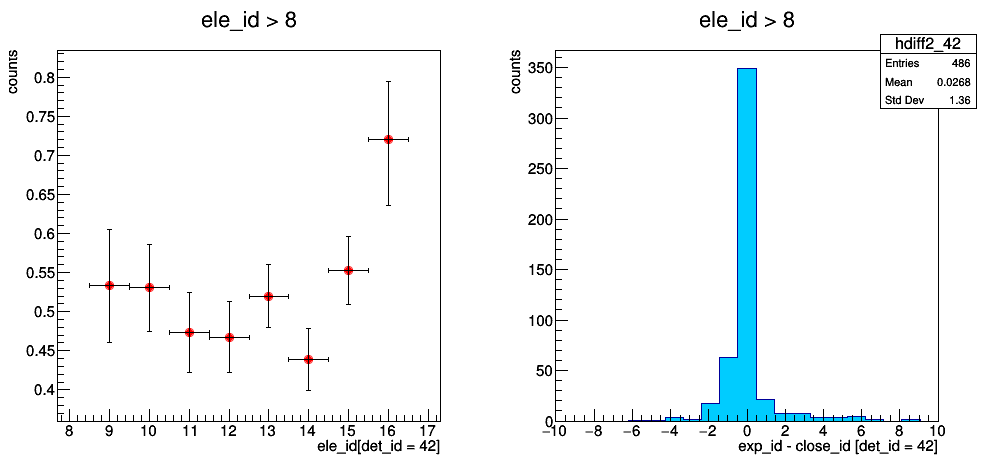

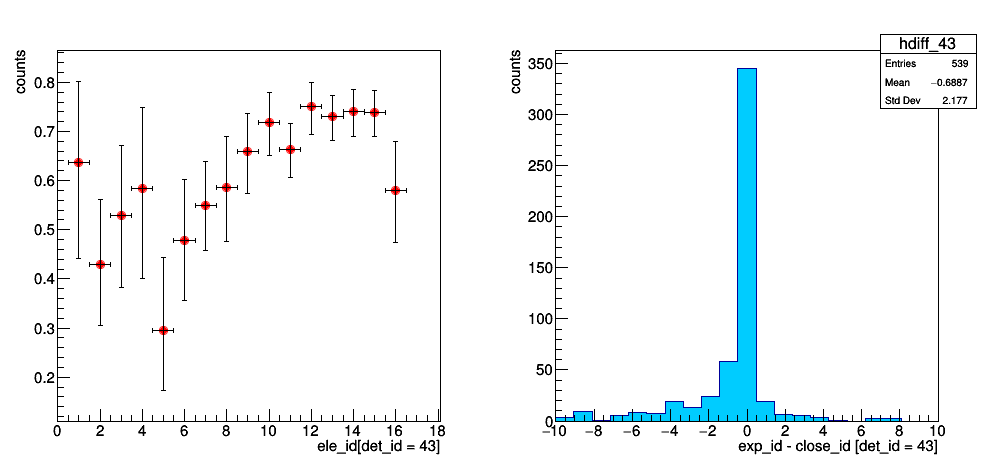

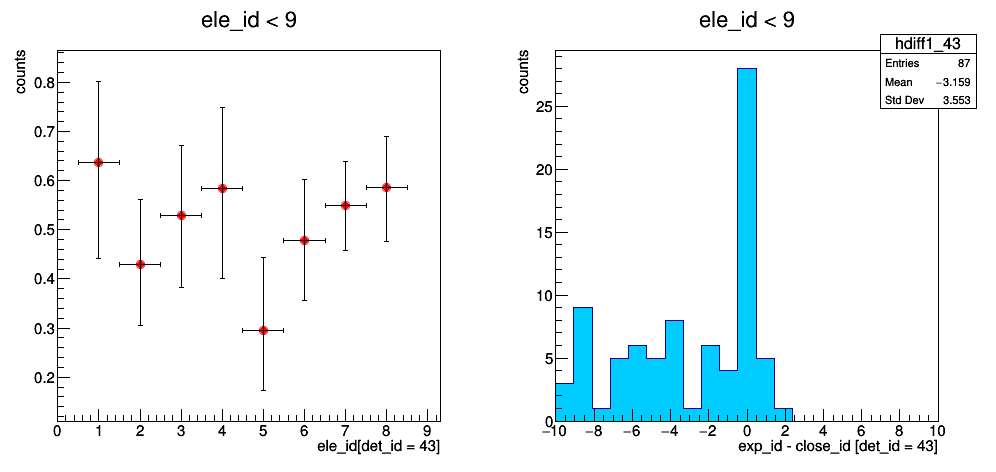

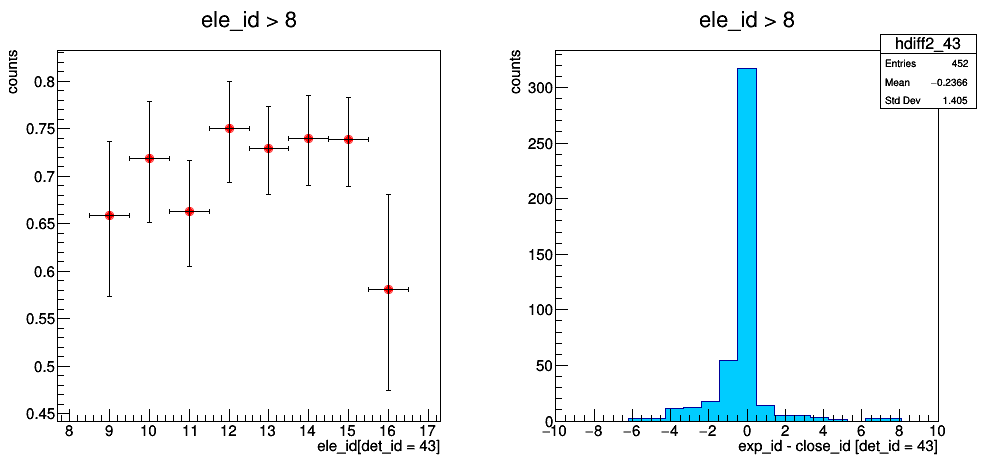

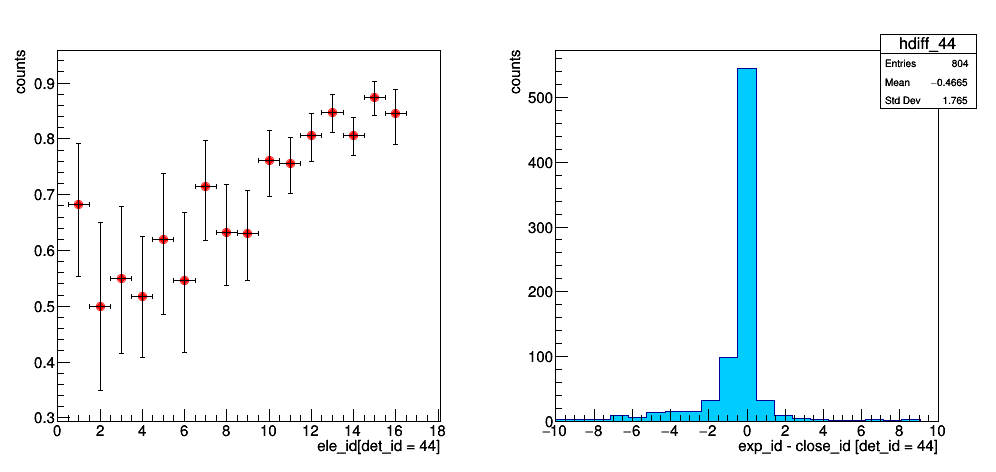

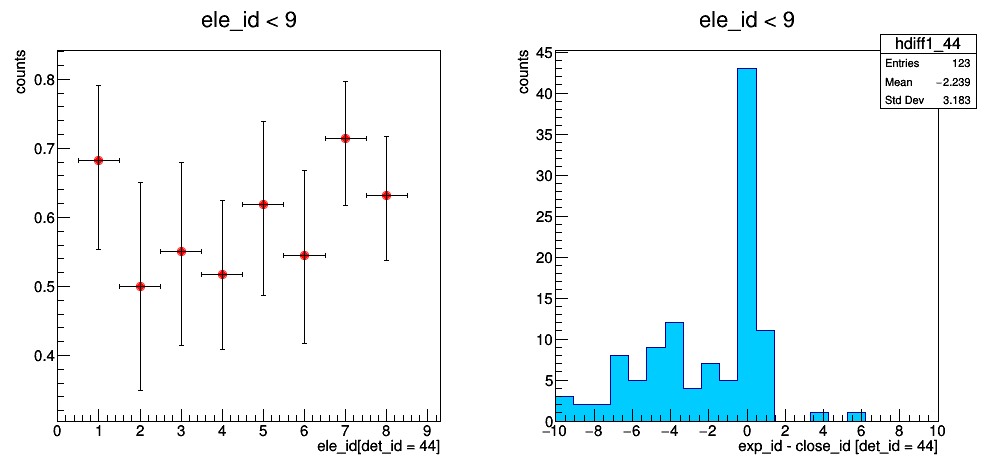

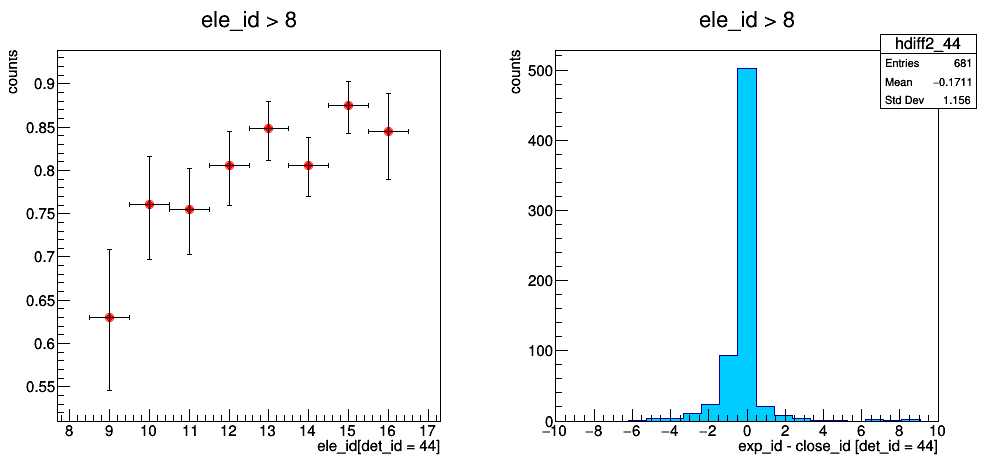

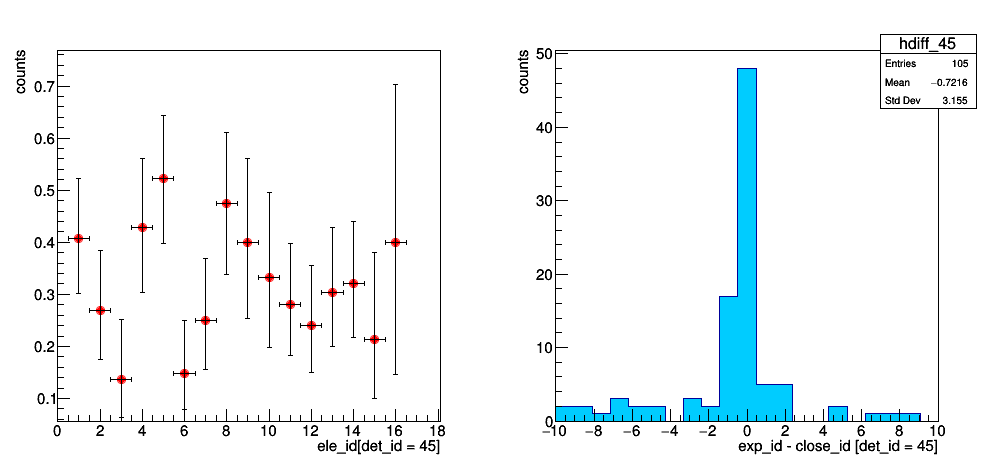

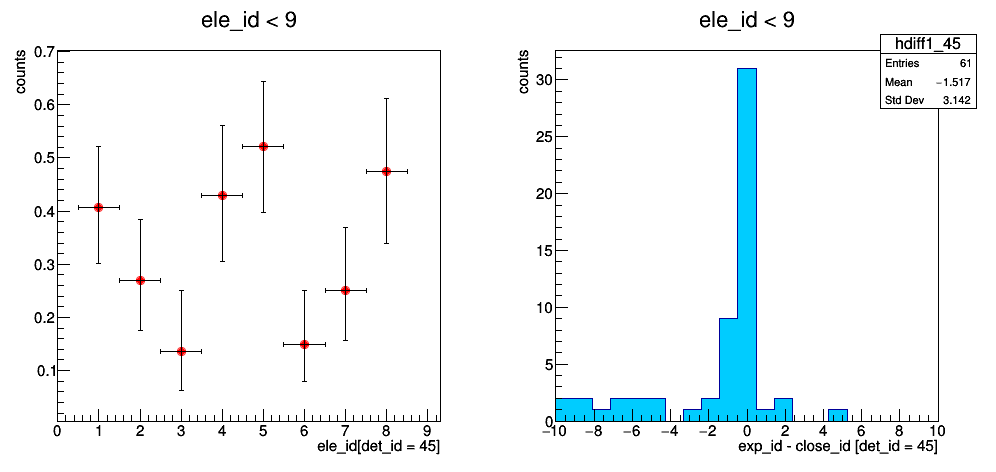

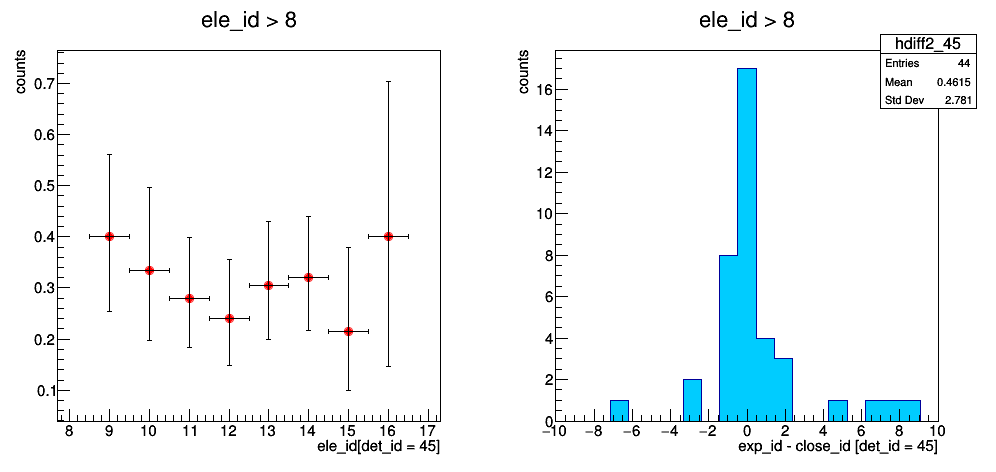

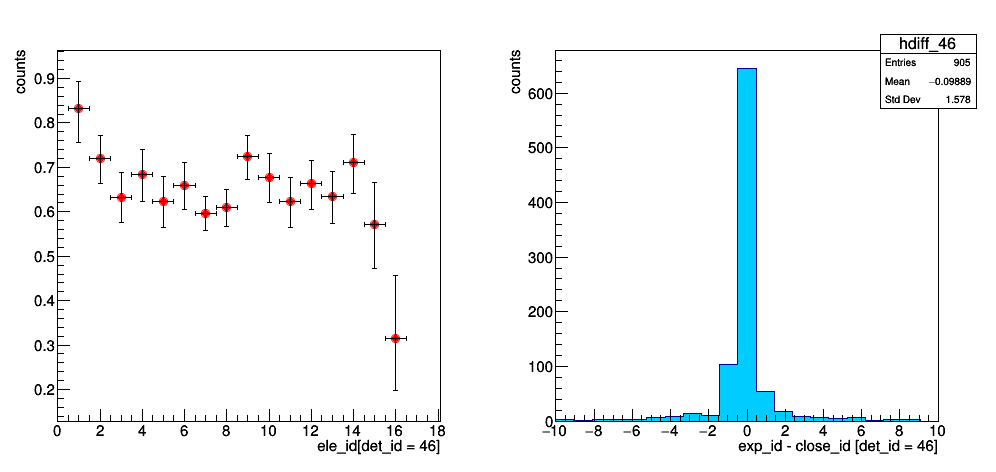

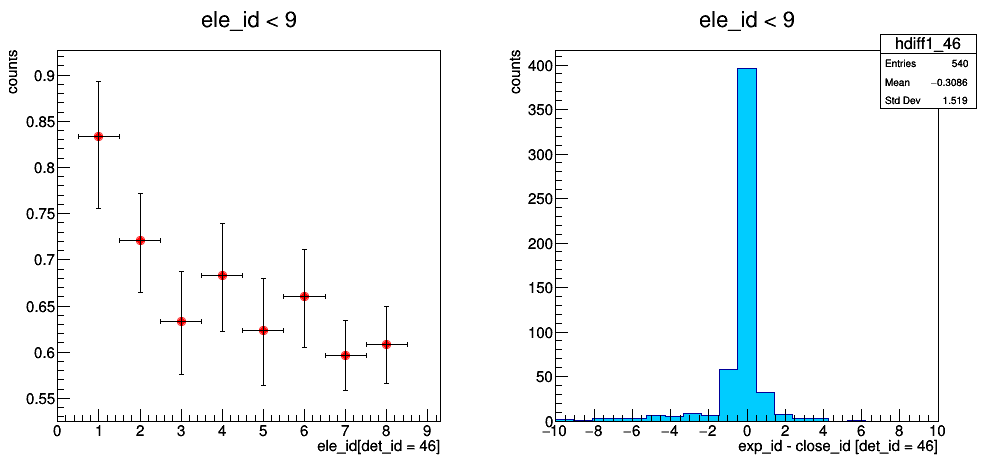

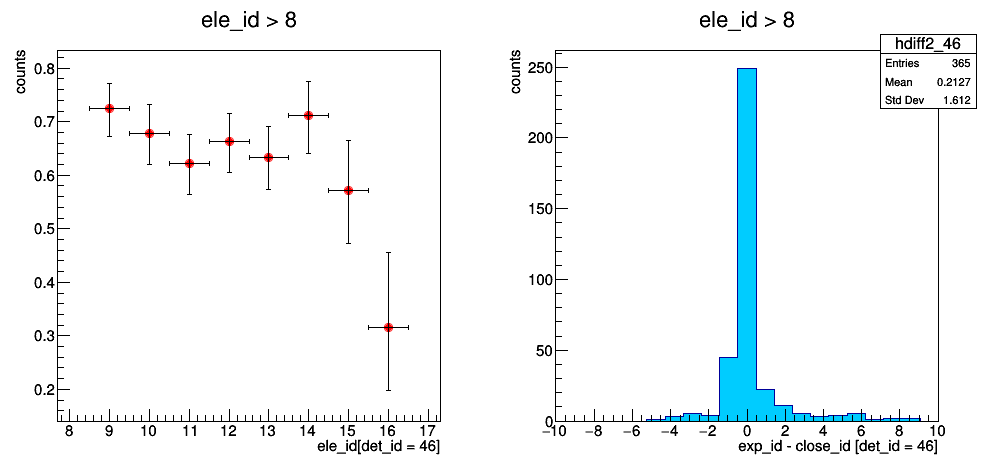

Info in <TCanvas::Print>: png file ../pics/nhits.png has been created
Info in <TCanvas::Print>: png file ../pics/chisq.png has been created
Info in <TCanvas::Print>: png file ../pics/ele24.png has been created
Info in <TCanvas::Print>: png file ../pics/ele42.png has been created
Info in <TCanvas::Print>: png file ../pics/effi_41.png has been created
Info in <TCanvas::Print>: png file ../pics/effi1_41.png has been created
Info in <TCanvas::Print>: png file ../pics/effi2_41.png has been created
Info in <TCanvas::Print>: png file ../pics/effi_42.png has been created
Info in <TCanvas::Print>: png file ../pics/effi1_42.png has been created
Info in <TCanvas::Print>: png file ../pics/effi2_42.png has been created
Info in <TCanvas::Print>: png file ../pics/effi_43.png has been created
Info in <TCanvas::Print>: png file ../pics/effi1_43.png has been created
Info in <TCanvas::Print>: png file ../pics/effi2_43.png has been created
Info in <TCanvas::Print>: png file ../pics/effi_44.png has been cr

In [12]:
// set hodo ids
vector<int> hodo = {41, 42, 43, 44, 45, 46};
int nhodo = hodo.size();

//cout << nhodo << endl;

// do ana
model* m = new model();
for(int i = 0; i < nhodo; i++){m->set_det(hodo.at(i));}
m->ana();
m->done();